# 11주차(목) 실습문제 - 신뢰구간 추정과 가설검정

제출시 HTML(.html) 형식으로 다운로드한 뒤, 올려주세요.

In [1]:
# 수치 계산에 사용하는 라이브러리
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats

# 그래프를 그리기 위한 라이브러리
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

# 표시 자릿수 지정
%precision 3
# 그래프를 주피터 노트북에 그리기 위한 설정
%matplotlib inline

---

## 1. 점 추정과 신뢰구간
아래 데이터 읽기 코드를 먼저 실행하고, height 데이터에 대해 아래 문제를 푸시오.

In [2]:
data = pd.read_csv("health2018.csv")
height = data[data.sex == 'F'].height

### 1-1. 여성 키 데이터 height에서 모평균과 모분산의 점추정 값을 구하시오. 

In [3]:
m = height.mean()
var = height.var(ddof=1)  # 불편분산
print(m, var)

157.53676470588263 43.34178514666145


### 1-2. 샘플사이즈 10일 때, 표본평균의 90% 신뢰구간을 구하시오.
힌트: 자유도 9의 t분포 사용.

In [4]:
sigma = height.std(ddof=1)
SEM = sigma / np.sqrt(10)
interval = stats.t.interval(alpha = 0.90, df = 9, loc = m, scale = SEM)
interval

(153.72046372603444, 161.35306568573083)

### 1-3. 복원추출로 샘플사이즈 10의 표본평균을 1000번 구하고, 그중 위 신뢰구간에 들어가는 비율을 계산하시오.

In [5]:
np.random.seed(1)
within_interval = np.zeros(1000, dtype = "bool")

for i in range(0, 1000):
    sample = np.random.choice(height, size = 10, replace = True)
    sample_mean = sample.mean()
    if (interval[0] < sample_mean and interval[1] > sample_mean):
        within_interval[i] = True
        
within_interval.mean()

0.936

---

## 2. t검정과 그룹 비교 시각화
아래 코드를 이용해 19세 남성과 19세 여성의 데이터를 10개씩 추출해 data2에 저장한다. 

In [6]:
data_man = data[(data.age==19) & (data.sex=='M')][0:10]
data_woman = data[(data.age==19) & (data.sex=='F')][0:10]

data2 = pd.concat([data_man, data_woman])

<AxesSubplot:xlabel='sex', ylabel='BMI'>

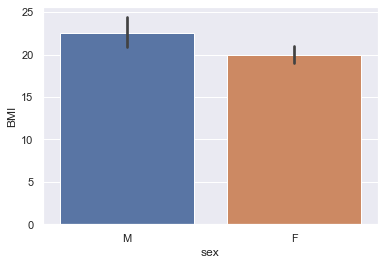

In [7]:
sns.barplot(data = data2, x='sex', y='BMI')

### 2-1. 위와 같이 sns.barplot을 이용해 남성과 여성의 BMI 평균값을 막대그래프로 표시하였다. 남성과 여성 표본에서 95% 신뢰구간을 t분포에 기반해 계산하고, 그래프의 오차막대와 일치하는지 확인하라.

In [8]:
group_mean = data2.groupby('sex')['BMI'].mean()
group_SEM = data2.groupby('sex')['BMI'].std(ddof=1) / np.sqrt(10)    # std() 디폴트가 ddof=1이라서 .std()로만 써도 됨.
print(group_mean, group_SEM)

interval_m = stats.t.interval(alpha = 0.95, df = 9, loc = 22.578178, scale = 0.924528)
interval_f = stats.t.interval(alpha = 0.95, df = 9, loc = 19.998649, scale = 0.552725)
print(interval_m, interval_f)

sex
F    19.998649
M    22.578178
Name: BMI, dtype: float64 sex
F    0.552725
M    0.924528
Name: BMI, dtype: float64
(20.4867503626454, 24.669605637354604) (18.748298182223987, 21.248999817776014)


### 2-2. 대응표본 t검정과 독립표본 t검정을 사용해 남성과 여성의 BMI 평균이 다른지 검정하라 (두 p값을 비교해보라).
이 경우, 대응표본 t검정과 독립표본 t검정 중 어느 방법이 더 적절한가? 왜 그러한지 설명하시오.

In [21]:
[T_paired, p_paired] = stats.ttest_rel(data2[data2.sex=='M']['BMI'], data2[data2.sex=='F']['BMI'])
print(T_paired, p_paired)
[T_independent, p_independent] = stats.ttest_ind(data2[data2.sex=='M']['BMI'], data2[data2.sex=='F']['BMI'], equal_var = False)
print(T_independent, p_independent)

2.1839532152377092 0.05680736151004805
2.394767153966043 0.03042517147864766


---

## 3. 분할표 검정 및 시각화

In [10]:
data3 = data[data.age<=20]    # 만 19~20세 남녀.
len(data3)

111

### 3-1. BMI 25 이상인 사람은 '비만', BMI 23 미만은 '정상'으로 분류한 뒤, 성별에 따라 비만 빈도를 표시하는 분할표(교차표)를 생성하라. 또한 남성, 여성 각각에서 비만의 비율을 구하라.
힌트: ?pd.crosstab 도움말에서 normalize 옵션을 참고하시오.

In [11]:
data3['Obesity'] = ['비만' if bmi>=25 else '정상' for bmi in data3['BMI']]
pd.crosstab(data3.sex, data3.Obesity)

<ipython-input-11-5ca1c63f13cc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data3['Obesity'] = ['비만' if bmi>=25 else '정상' for bmi in data3['BMI']]


Obesity,비만,정상
sex,,
F,7,54
M,11,39


In [18]:
pd.crosstab(data3.sex, data3.Obesity, normalize = 'index')

Obesity,비만,정상
sex,,
F,0.114754,0.885246
M,0.220000,0.780000


### 3-2. 분할표 검정(카이제곱 검정)을 시행해 성별에 따라 과체중의 빈도가 다른지 p값을 구하시오.

In [19]:
cross = pd.crosstab(data3.sex, data3.Obesity)
sp.stats.chi2_contingency(cross, correction = False)

(2.240153358011634,
 0.13446764312934373,
 1,
 array([[ 9.892, 51.108],
        [ 8.108, 41.892]]))

### 3-3. 위의 분할표에서 관찰된 샘플 수가 모두 2배가 된다면, 분할표 검정 결과는 어떻게 되는가?

In [13]:
cross2 = cross *2
sp.stats.chi2_contingency(cross2, correction = False)

(4.480306716023268,
 0.03428756718303286,
 1,
 array([[ 19.784, 102.216],
        [ 16.216,  83.784]]))